# Optimization

The *optimization* problem is to find maxima and minima of an *objective function*. Optimization is often referred to as `minimization`, because maximization can be formulated as minimizing its negative value. 

Optimization is closely related to root finding: because at the minima the slope is zero for smooth functions. In general, this only find a local extremum.

Learning objectives:
 - Golden section method
 - Successive parabolic interpolation
 - MATLAB function `fminbnd`

## Golden Section Search

The golden-section search for minimization is analogous to the bisection method for root finding. It starts with an interval with opposite signs of slopes, and repeatedly shrinks the interval until the length of interval is within some tolerance.

<img src="https://drive.google.com/uc?export=download&id=0ByTwsK5_Tl_PTWgtXzRkczZTckk" width="400">
<img src="https://drive.google.com/uc?export=download&id=0ByTwsK5_Tl_POVluTl84ZThQSjA" width="280">

The following code implements the method.

In [1]:
function [x, k] = golden_section(f, a, b, tol)
% GOLDEN_SECTION finds a minimum of f(x) within the interval [a,b]
% using the golden-section search. It assumes f has negative slope 
% at a and positive slope at b.

tau = (sqrt(5) - 1) / 2;
x1 = a + (1 - tau) * (b - a); f1 = f(x1);
x2 = a + tau * (b - a); f2 = f(x2);

k = 0;
while b-a > tol
    if (f1 > f2)
        a = x1; 
        x1 = x2;
        f1 = f2;
        x2 = a + tau * (b-a);
        f2 = f(x2);
    else
        b = x2; 
        x2 = x1;
        f2 = f1;
        x1 = a + (1 - tau) * (b-a);
        f1 = f(x1);
    end
    k = k + 1;
end

x = (a + b) / 2;
end

In MATLAB, you need to save the above function definition into an M-file named `golden_section.m`. 

To call `golden_section`, we can use [anonymous functions](https://www.mathworks.com/help/matlab/matlab_prog/anonymous-functions.html), which are similar to the [lambda functions in Python](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions).

x=0.3003756217409748 after 77 iterations, and f(x) is -96.50140856037187


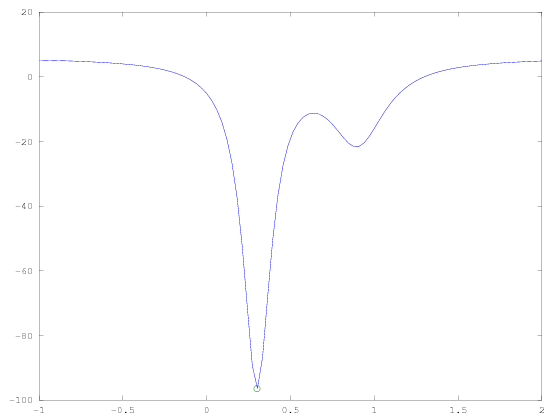

In [2]:
% We define an anonymous function
f = @(x) -(1 ./ ((x-.3).^2 + .01) + 1 ./ ((x-.9).^2 + .04) - 6);

[x, k] = golden_section(f, -1, 2, eps);
fprintf('x=%.16g after %d iterations, and f(x) is %.16g\n', x, k, f(x));

xs = linspace(-1, 2);
plot(xs, f(xs), '-', x, f(x), 'o')

In the golden-section search, the length of the interval is reduced by about $38.2\%$ each step. It is a slow but robust method.

## Successive Parabolic Interpolation

The successive parabolic interpolation for minimization is analogous to the secant method to root finding. It uses three points to construct a quadratic interpolation.
<img src="https://drive.google.com/uc?export=download&id=0ByTwsK5_Tl_PNVJicTNweWNFOWs" width="400">

The following code illustrates the idea:

In [3]:
function [x, k] = spi(f, a, b, tol)
% SPI minimizes f(x) using successive parabolic interpolation.

maxiter = 100;

xs = [a, (a+b)/2, b]; fx = f(xs);

for k = 1:maxiter
    p = polyfit(xs, fx, 2);
    x = -0.5*p(2)/p(1);
    
    xs = [xs(2:end), x];
    fx = [fx(2:end), f(x)];

    if abs(xs(3)-xs(2)) < tol * abs(xs(2));
        break
    end
end

x = xs(end);
end

In MATLAB, you need to save the above function definition into an M-file named `spi.m`.

x=0.6370089873583797 after 8 iterations, and f(x) is -11.25275412569616


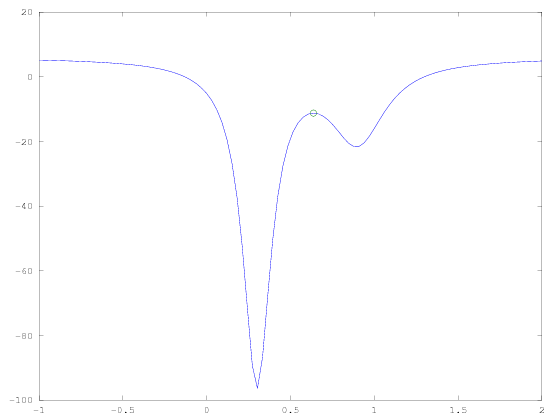

In [4]:
f = @(x) -(1 ./ ((x-.3).^2 + .01) + 1 ./ ((x-.9).^2 + .04) - 6);

[x, k] = spi(f, 0, 0.7, 1.e-5);

fprintf('x=%.16g after %d iterations, and f(x) is %.16g\n', x, k, f(x));

xs = linspace(-1, 2);
plot(xs, f(xs), '-', x, f(x), 'o')

Successive parabolic interpolation may not converge or may converge to some undesired value.

## Hybrid Method for Efficiency and Robustness
 
The MATLAB function `fminbnd` combines the golden-section search and successive parabolic interpolation, analogous to the robust method `fzero` for root finding. This method was due to Richard Brent, and hence it is sometimes referred to as Brent's method. 

The following is a simplified implementation of `fminbnd`.

In [5]:
function u = fminbndtx(F,a,b,tol,varargin)
%FMINBNDTX  Textbook version of FMINBND
%   x = FMINBNDTX(F,a,b) finds a local minimizer x of the function F
%   in the interval a <= x <= b. F accepts scalar input x and returns 
%   a scalar function value, F(x).
%
%   x = FMINBNDTX(F,a,b,tol) uses stopping tolerance tol instead of 1.e-6.
%
%   x = FMINBNDTX(F,a,b,tol,p1,p2,...) provides for additional
%   arguments, which are passed to the objective function, F(x,p1,p2,...).
%   (Use [] as a place holder for tol to get the default tolerance.)
%
%   Example
%      x = fminbndtx(@cos,3,4)
%      computes pi to six decimal places.
%
%   See also FMINBND, FMINSEARCH, FZERO, @, INLINE.

%   Copyright 2014 Cleve Moler
%   Copyright 2014 The MathWorks, Inc.
%   Reference: "Computer Methods for Mathematical Computations",
%   Forsythe, Malcolm, and Moler, Prentice-Hall, 1976.

% Initialization

if nargin < 4 | isempty(tol)
   tol = 1.e-6; 
end

phi = (1 + sqrt(5))/2;
rho = 2 - phi;
u = a + rho*(b-a);
v = u; w = u; x = u;
fu = F(u,varargin{:}); 
fv = fu; fw = fu; fx = fu;
xm = 0.5*(a+b);
d = 0.0;
e = 0.0;

% Main loop

while abs(x-xm) > tol
   % Is a parabolic fit possible?
   para = abs(e) > tol;
   if para
      % Try parabolic fit.
      r = (x-w)*(fx-fv);
      q = (x-v)*(fx-fw);
      p = (x-v)*q-(x-w)*r;
      s = 2*(q-r);
      if s > 0.0, p = -p; end
      s = abs(s);
      % Is the parabola acceptable?
      para = ( (abs(p)<abs(0.5*s*e)) & (p>s*(a-x)) & (p<s*(b-x)) );
      if para
         % Parabolic interpolation step
         e = d;
         d = p/s;
      end
   end
   if ~para
      % Golden-section step
      if x >= xm
         e = a-x;
      else
         e = b-x;
      end
      d = rho*e;
   end
   
   u = x + d;
   fu = F(u,varargin{:});  
   
   % Update a, b, x, v, w, xm
   if fu <= fx
      if u >= x, a = x; else, b = x; end
      v = w; fv = fw;
      w = x; fw = fx;
      x = u; fx = fu;
   else
      if u < x, a = u; else, b = u; end
      if ( (fu <= fw) || (w == x) )
         v = w; fv = fw;
         w = u; fw = fu;
      elseif ( (fu <= fv) || (v == x) || (v == w) )
         v = u; fv = fu;
      end
   end
   xm = 0.5*(a+b);
end
end

In MATLAB, you need to save the above function definition into an M-file named `fminbndtx.m`.

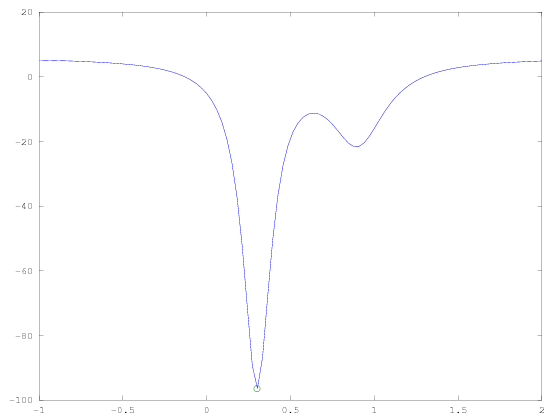

In [6]:
x = fminbndtx(f, 0, 0.7, 1.e-5);

xs = linspace(-1, 2);
plot(xs, f(xs), '-', x, f(x), 'o')

Acknowledgment: The material in this Notebook was adapted from Chapter 4 of Numerical Computing with MATLAB by Cleve Moler, 2004.